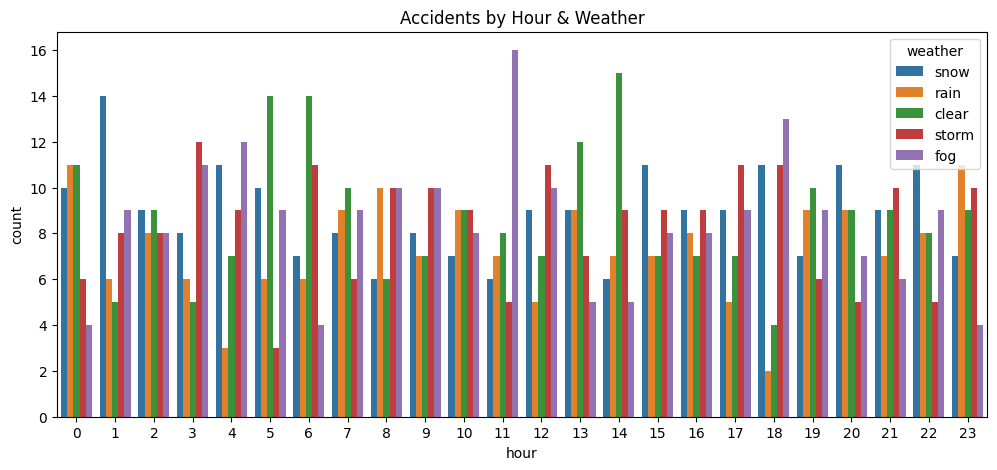

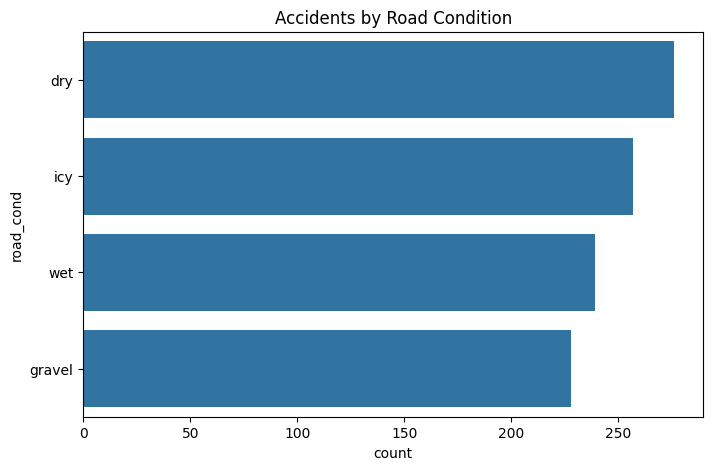

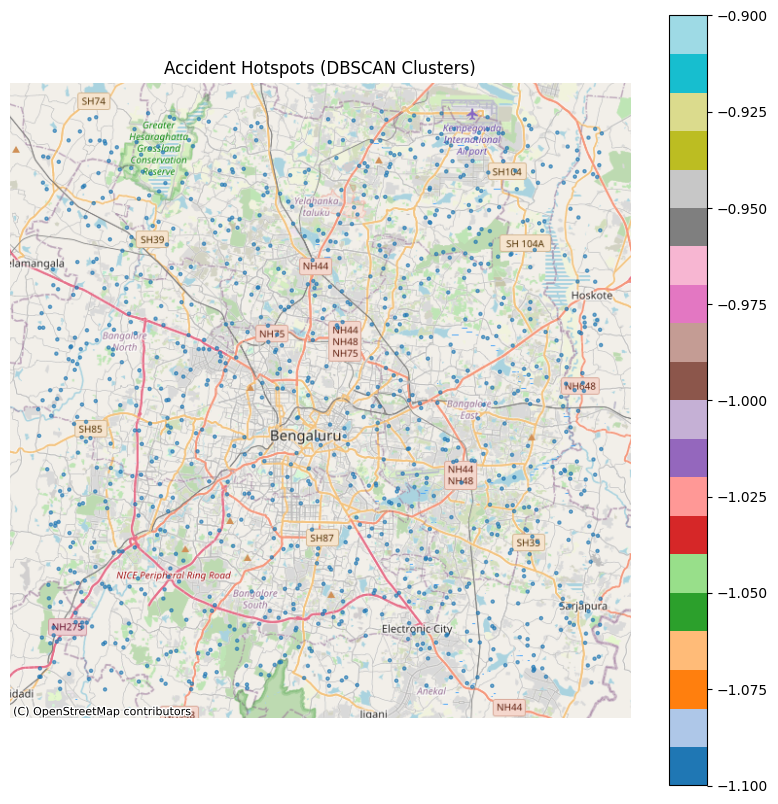

KeyError: 'cluster'

In [7]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.cluster import DBSCAN
import contextily as ctx

# 1. Load data
url="C:/kavin/accident_data.csv"
df = pd.read_csv(url, parse_dates=["datetime"])

# 2. Preprocess
df.dropna(subset=["latitude", "longitude"], inplace=True)
df["hour"] = df["datetime"].dt.hour
df["weather"] = df["weather"].str.lower()
df["road_cond"] = df["road_conditions"].str.lower()

# 3. Patterns by time/condition
plt.figure(figsize=(12,5))
sns.countplot(data=df, x="hour", hue="weather")
plt.title("Accidents by Hour & Weather")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(data=df, y="road_cond", order=df["road_cond"].value_counts().index)
plt.title("Accidents by Road Condition")
plt.show()

# 4. Accident hotspots (DBSCAN spatial clustering)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)  # Web Mercator

coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))
db = DBSCAN(eps=300, min_samples=10).fit(coords)
gdf["cluster"] = db.labels_

# 5. Plot map of clusters
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, column="cluster", cmap="tab20", markersize=5, alpha=0.6, legend=True)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Accident Hotspots (DBSCAN Clusters)")
plt.show()

# 6. Contributing factors per cluster
cluster_summary = df.groupby("cluster").agg({
    "weather": lambda x: x.mode()[0],
    "road_cond": lambda x: x.mode()[0],
    "hour": "median",
    "severity": "mean"
}).reset_index()
print(cluster_summary)
